### Intro
- Explain problem and objective
- Cite some previous work and most commonly used algorithms (bag of words, tfidf, w2v)

### Dataset

 - how do we collect data. Explain method and reasons. (Look into replies, using lexicon traduced in france, etc. )
 - explain labels and their definition. Explain that at the end we choose to re-group in two cathegories to accelerate the process, but the code is ready for multi-class classification
 - overview of the dataset (% of N /H tweets, size, ... )

### Data cleaning and feature selection
We tried several different ways to build features.

#### Pre-processing
First, the tweets are always pre-processed by 
- lowercasing
- removing punctuation and numbers
- removing urls (but N. of urls used as feature) (con be improved, e.g. keep only main url part, for example name of the site)
- removing mentions
- removing hashtags (but n. of ht used as feature) (can be improved, e.g. use hashtag as features )
- removing special characters and smileys (can be improved, e.g. smileys can proxy sentiment)

Then, we tried two different approaches:
 
  1\.  not stemming and keeping stopwords
 
  2\.  stemming and removing stopwords

This choice is motivated by the fact that we wanted to ascertain whether removing stopwords and stemming influences the features by changing the context of a word. For example, the expression "I'm not racist, but...", often associated with racist content, wold become just "racist" after removing stopwords. An example is given below.


In [5]:
print("Original: \n %s \n" %text)
print("No stemming: \n %s \n" %t1)
print("With stemming: \n %s \n" %t2)
print("With stemming and removing stopwords: \n %s \n" %t3)
print("Tokenization (with stopwords and no stemming): \n %s \n" %t4)


Original: 
 En effet, il a pas célébré https://t.co/fhwjTEyhMV 

No stemming: 
 en effet il a pas celebre 

With stemming: 
 en effet il a pas celebr 

With stemming and removing stopwords: 
 effet celebr 

Tokenization (with stopwords and no stemming): 
 ['en', 'effet', 'il', 'a', 'pas', 'celebre'] 



%%latex
#### Features

We also tried to build features in several ways: 

a\. TF-IFD vectorizer with n-gram features ($ 1<=n<=3 $), fitted on the labeled dataset. We shall refer to these as "TF-IDF" features. The features dimensions are set to 90% the size of the dataset, to reduce overfitting. 

b\. Word-to-vec (w2v) vectorizer fitted on an unlabeled dataset of 1 milion tweets. This vectorizer maps each word into an n-dimensional feature vector. We choose $n=300$. Then, to build features, we average the word vectors of all words in a tweet. We shall refer to these as "unweighted" features

c\. w2v vectorizer fitted on an unlabeled dataset of 1 milion tweets. This time, before averaging, we weight each word vector with its TF-IDF weight. We shall refer to these as "weighted" features. Not that this require a somewhat longer computation time
Reference: http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

d\. Finally, we tried to re-train the w2v vectorizer on a subsample of the original 1-milion-long dataset. The subsample is selected by computing the 'similarity' between the average vector of the labeled dataset, and the features of the unlabeled dataset. The similarity is defined as the cosine between the two vectors in the features' space. The subsample is selected setting a threshold similarity of 0.5 and keeping only tweets more than 5 words long. 


### Classifiers and results

We train classifiers for the four set of features above. For each of the one, we try different algorthms: Logistic Regression, SVM, and Random Forest. We run a grid parameter search and maximize the recall in the "positive" class (i.e., the class labeled as "Hateful" or "Racist"). This choice is motivated by two facts:
- the two classes are highly umbalanced with a large majority of the tweets being "Neutral"
- if the goal is to detect and signal a racist tweet, we thought that predicting a racist tweet as "Neutral" is a worst case than its opposite (signaling a tweet that is actually neutral - we assume that ultimately the tweets labeled as "H" or "N" are reviewed by humans). So, we minimize the false negative rate. 

###### I put all the results here for us. In the final version we may keep only the confusion matrix for the best one and make a table with results for the others...

#### FEATURES 2 - STEMMING AND REMOVING STOPWORDS

We also tried using features without stemming and keeping stopwords, but this results in an overall worse performance. So we show results only for the best case.

#### 1. TFIDF

             precision    recall  f1-score   support

        0.0       0.65      0.44      0.52        73
        1.0       0.92      0.96      0.94       473

avg / total       0.88      0.89      0.88       546



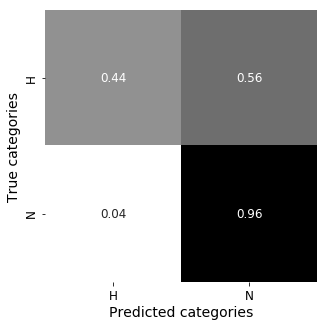

In [9]:
print(classification_report( y_test_tfidf, y_preds_rf ))
cm_rf = print_cm(y_test_tfidf, y_preds_rf , ['H','N'])

#### 2. Unweighted w2v

             precision    recall  f1-score   support

        0.0       0.18      0.62      0.28        73
        1.0       0.91      0.57      0.70       473

avg / total       0.81      0.58      0.64       546



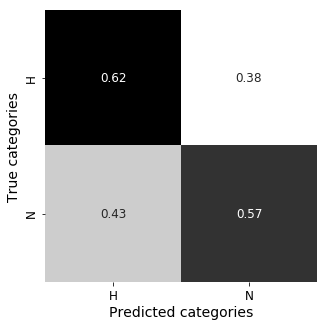

In [12]:
print(classification_report( y_test_not_weighted, y_preds_uw ))
cm_uw = print_cm(y_test_not_weighted, y_preds_uw , ['H','N'])

#### 3. Weighted w2v, full dataset

             precision    recall  f1-score   support

        0.0       0.34      0.74      0.47        73
        1.0       0.95      0.78      0.86       473

avg / total       0.87      0.77      0.80       546



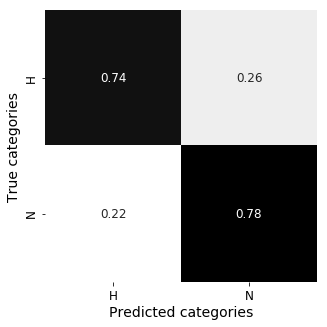

In [10]:
print(classification_report( y_test_1M, y_preds_w ))

cm_w = print_cm(y_test_1M, y_preds_w , ['H','N'])

#### Weighted w2v, selected dataset

             precision    recall  f1-score   support

        0.0       0.32      0.68      0.44        73
        1.0       0.94      0.78      0.85       473

avg / total       0.86      0.77      0.80       546



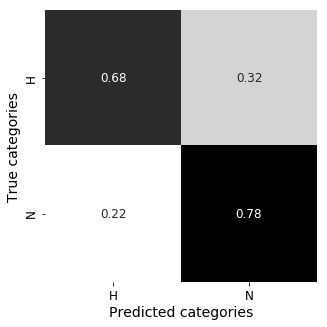

In [15]:
print(classification_report( y_test_1M, y_preds_sw ))

cm_sw = print_cm(y_test_selected, y_preds_sw , ['H','N'])

#### Undersampling
Finally, as the two label classes were highly unbalanced, we tried to train the classifier on a balanced sample. This is done with a random undersampling. The resulting dataset is small (544 tweets in each class)

             precision    recall  f1-score   support

        0.0       0.73      0.79      0.76        56
        1.0       0.76      0.70      0.73        53

avg / total       0.74      0.74      0.74       109



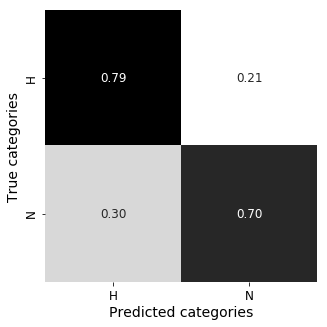

In [17]:
print(classification_report( y_res_test, y_preds_us ))
cm_us = print_cm(y_res_test, y_preds_us , ['H','N'])

### Best model and comments

As for the w2v features, in general, the weighted scheme seem to perform better than the unweighted. So, the higher evaluation time is worth. 
Also, w2v does significantly better than Tf-Idf alone.
On the other hand, it is not completely clear if using selected features gives better performance.

Conclusion: the best model is a Logistic Regression with l1 reg. and C=1 .
It seem to work (slightly) better with  w2v trained on the full sample rather than on the selected sample (why? Because the selected sample it's trained with less data? ). However, the difference is tiny and more investigation seems important (e.g. cross-validation).

If we use a Tf-Idf vectorizer, we get that the best classifier is a Random Forest with gini criterion. This does considerably worse that w2v+log reg if we consider the False positive rate (predicted =N but true=H ), and better if we consider the false negative (predicted=H but true=N). 
Since it's better to minimize false positive rate, we conclude that w2v works better.  

Finally, using undersampling techniques may improve the performace, in particular on the false positive rate, even if the size of the dataset is highly reduced. Given the small amount of data available, however, this risks to worsen the classifier's performance when applied to previously unseen data, and also the performance can fluctuate considerably when changing subsampling. However, this result is interesting to keep in mind if one has a larger dataset.

#### TO DO :
 - In general, to better comment performance we need to cross-validate ! Otherwise the results fluctuate too much (this is natural given the nature of the dataset)
 - Show a sample of misclassified tweets and try to comment reason of misclassification
 - Can we show the most relevant features correlated to the labels N and N in case of w2v ? How ? Not crucial but would be nice for the presentation
 - Add discussion on limitations (especially bad and biased dataset) 
 - Discuss results : it's very nice that we have a pipeline that works from the beginning to the end. We also have a clever way to exploit limitations due to manual labeling - i.e. train w2v on a large  unlabeled dataset. This can be important given the volume of data available. It would be nice to see if this technique helps to overcome limitations of other works. Finally, the idea of lookng into replies could eliminate bias in the labeled dataset. Also, at a glance, we recover many of the results of our main reference, 1703.04009,  even if with a lot worse dataset . In particular, see their discussion on the reasons of misclassifications. Underline anyway that we concentrate on developing the code rather than on writing a paper on language recognition; still, we improved existing work and the only thing missing to produce novel results is a good dataset (so it's just a matter of time). To support this conclusion, we could run the code (with appropriate modifications) on the dataset in english, and see how it does
 
#### Final (important) question. Given all the results we have here, one natural question if we publish a post like this would be: if you claim to have good stuff but bad data, and that collecting them is just a matter of time, why don't you just wait two or three months collecting data and then publish something? Well, why not ? Unless we are in a hurry to release the code on git.... 